In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from math import pi
import matplotlib.pyplot as plt

In [274]:
class WindowingModule(nn.Module):
    
    def __init__(
        self,
        x: torch.tensor,
        win_length: float,
        support: int,
        stride: int,
        fs: int,
        win_min: float | None = None,
        win_max: float | None = None,
        stride_min: float | None = None,
        stride_max: float | None = None,
        win_requires_grad: bool = True,
        stride_requires_grad: bool = True,
        tapering_function: str = "hann",

    ):
        super().__init__()

        self.N = support
        self.batch_size = x.shape[0]
        self.L=x.shape[-1]
        self.device = x.device
        self.dtype = x.dtype
        self.win_requires_grad = win_requires_grad
        self.stride_requires_grad = stride_requires_grad
        self.tapering_function = tapering_function
        self.fs = fs
        
        #Training control
        self.loss_rcd=[]
        self.strides_lt=[]
        self.winlen_lt=[]
        self.gd_strides_lt=[]
        self.gd_winlen_lt=[]
        self.gnorm_strides=[]
        self.gnorm_winlen=[]
        self.gnorm_total=[]
        self.gd_v_ratio_strides=[]
        self.gd_v_ratio_winlen=[]
        self.gd_v_ratio_total=[]

        if win_min is None:
            self.win_min = self.N / 20
        else:
            self.win_min = win_min

        if win_max is None:
            self.win_max = self.N
        else:
            self.win_max = win_max

        if stride_min is None:
            self.stride_min = 0
        else:
            self.stride_min = stride_min

        if stride_max is None:
            self.stride_max = max(self.N, abs(stride))
        else:
            self.stride_max = stride_max

        self.tap_win = None
        self.actual_win_length=None
        self.actual_strides=None

        #self.T = 1 + int(torch.div(self.L, stride, rounding_mode="floor")) ### Why 1 +
        self.T = int(torch.div(self.L, stride, rounding_mode="floor"))
        
        self.init_stride = abs(stride)
        self.strides = nn.Parameter(
            torch.full(
                (self.T,),
                self.init_stride,
                dtype=self.dtype,
                device=self.device),
                requires_grad=self.stride_requires_grad)
        
        self.init_win_length=win_length
        self.win_length= nn.Parameter(
            torch.full(
                (self.T,),
                self.init_win_length,
                dtype=self.dtype,
                device=self.device),
            requires_grad=self.win_requires_grad)
    
    @property
    def frames(self):
        # Compute the temporal position (indices) of frames (support)
            #expanded_stride = self.actual_strides.expand((self.T,))
        expanded_stride = self.actual_strides
        frames = torch.zeros_like(expanded_stride)
        frames -= self.N / 2 + self.init_stride
        frames += expanded_stride.cumsum(dim=0)
        return frames

    def forward(self, x: torch.tensor)-> torch.tensor:
        #self.window_function('forward')
        #output=self.operation_v1(x)
        output=self.operation(x)
        return output
    
    #def backward(self: WindowingModule, x: torch.tensor):
    #    pass

    """
    def operation_v1(self, x: torch.tensor):
        self.actual_strides=self.stride_transform(self.strides)
        limits=[(int(i*self.actual_strides[i]),int(i*self.actual_strides[i]+self.N)) for i in range(self.T)]
        #if limits[-1][-1] > self.L: # if equal no problem, it is supposed that never will be lower
        x_padded = torch.cat((x,torch.zeros((1,limits[-1][-1]-self.L))),axis=1)[0]
        val=torch.tensor(0.0)
        for i in range(self.T):
            val += torch.sum(x_padded[limits[i][0]:limits[i][1]]*self.tap_win[:,i])/self.win_length[i]
        return val
    """

    def operation(self, x: torch.tensor):
        self.actual_strides=self.stride_transform(self.strides)
        seg_sx, idx_frac = self.segment_signal(x)
        #self.window_function('forward',idx_frac)
        self.window_function(idx_frac)
        #val=torch.tensor(0.0)
        #for i in range(self.T):
        #    val += torch.sum(seg_sx[0,i,:]*self.tap_win[:,i])/self.win_length[i]
        result= torch.sum((seg_sx*(self.tap_win.permute(1,0)))/self.win_length.view(1, self.T, 1)) ###normalize win_length or actual_win_length
        #if not(torch.isclose(val,result)):
        #    print('not equal') 
        return  result 

    def window_transform(self, w_in):
        w_out = torch.minimum(
            torch.maximum(w_in, torch.full_like(w_in, self.win_min, dtype=self.dtype, device=self.device,),),
            torch.full_like(w_in, self.win_max, dtype=self.dtype, device=self.device,),)
        return w_out
    
    def stride_transform(self, s_in: torch.Tensor):  # born stride entre 0 et 2N
        s_out = torch.minimum(
            torch.maximum(s_in, torch.full_like(s_in, self.stride_min, dtype=self.dtype, device=self.device,),),
            torch.full_like(s_in, self.stride_max, dtype=self.dtype, device=self.device,),)
        return s_out
    
    def segment_signal(self, x: torch.tensor):
        idx_floor = self.frames.floor()
        idx_frac = self.frames - idx_floor
        idx_floor = idx_floor.long()[:, None].expand((self.T,self.N,)) + torch.arange(0, self.N, device=self.device)
        idx_floor[idx_floor >= self.L] = -1
        seg_sx=x[:,idx_floor]
        seg_sx[:, idx_floor < 0] = 0
        return seg_sx, idx_frac

    def window_function(self,idx_frac=0):
        if self.tapering_function not in {"hann", "hanning","gaussian","blackman"}:
            raise ValueError(
                f"tapering_function must be one of '{('hann', 'hanning','gaussian','blackman')}', but got padding_mode='{self.tapering_function}'",
            )
        else:
            self.actual_win_length=self.window_transform(self.win_length)
            if self.tapering_function=='hann':
                self.tap_win=self.windows_hann(idx_frac)
            elif self.tapering_function=='hanning':
                self.tap_win=self.windows_hann(idx_frac,alpha=0.54)
            elif self.tapering_function=='gaussian':
                self.tap_win=self.window_gaussian(idx_frac)
            elif self.tapering_function=='blackman':
                self.tap_win=self.window_blackman(idx_frac)

    """
    def window_function(self, direction: str, idx_frac=0) -> torch.tensor:
        if self.tapering_function not in {"hann", "hanning"}:
            raise ValueError(
                f"tapering_function must be one of '{('hann', 'hanning')}', but got padding_mode='{self.tapering_function}'",
            )
        else:
            # Create an array of indices to use as the base for the window function
            base = torch.arange(
                0, self.N, 1, dtype=self.dtype, device=self.device,
            )[:, None].expand([-1, self.T])
            base = base - idx_frac
            # Expand the win_length parameter to match the shape of the base array

        #self.actual_win_length=torch.mean(self.win_length) # !!!PARCHE!!!
        self.actual_win_length=self.window_transform(self.win_length)   
        
        # calculate the tapering function and its derivate w.r.t. window length
        mask1 = base.ge(torch.ceil((self.N - 1 + self.actual_win_length) / 2)) 
        mask2 = base.le(torch.floor((self.N - 1 - self.actual_win_length) / 2))
        if (
            self.tapering_function == "hann"
            or self.tapering_function == "hanning"
        ):
            if direction == "forward":
                self.tap_win = 0.5 - 0.5 * torch.cos(
                    2
                    * pi
                    * (base + (self.actual_win_length - self.N + 1) / 2)
                    / self.actual_win_length,
                )
                self.tap_win[mask1] = 0
                self.tap_win[mask2] = 0
                #self.t_win=self.windows_hann(idx_frac)
                # self.tap_win = self.tap_win / self.tap_win.sum(
                #    dim=0, keepdim=True,
                # )
                #return self.tap_win.pow(self.win_pow)
                #return self.tap_win
            elif direction == "backward":
               
                f = torch.sin(
                    2
                    * pi
                    * (base + (self.actual_win_length - self.N + 1) / 2)
                    / self.actual_win_length,
                )
                d_tap_win = (
                    -pi
                    / self.actual_win_length.pow(2)
                    * ((self.N - 1) / 2 - base)
                    * f
                )
                d_tap_win[mask1] = 0
                d_tap_win[mask2] = 0
                d_tap_win = d_tap_win / self.N * 2
                return d_tap_win
        return None
    """
    def windows_hann(self,shift,alpha=0.5):
        n=torch.arange(0,self.N)[:, None].expand([-1,self.T])-shift
        w=alpha-(1-alpha)*torch.cos(2*torch.pi*(n+(self.actual_win_length-self.N+1)/2)/self.actual_win_length)
        w[n<=torch.floor((self.N-1-self.actual_win_length)/2)]=0
        w[n>=torch.ceil((self.N-1+self.actual_win_length)/2)]=0
        return w

    def window_gaussian(self,shift,coef=4):
        sigma=self.actual_win_length/coef
        n=torch.arange(0,self.N)[:, None].expand([-1,self.T])-shift
        w=torch.exp(-0.5*((n-(self.N-1)/2)/sigma)**2)
        return w
    
    def window_blackman(self,shift):
        n=torch.arange(0,self.N)[:, None].expand([-1,self.T])-shift
        w=0.42-0.5*torch.cos(2*torch.pi*(n+(self.actual_win_length-self.N+1)/2)/self.actual_win_length)+0.08*torch.cos(4*torch.pi*(n+(self.actual_win_length-self.N+1)/2)/self.actual_win_length)
        w[n<=torch.floor((self.N-1-self.actual_win_length)/2)]=0
        w[n>=torch.ceil((self.N-1+self.actual_win_length)/2)]=0
        return w
    
    def save_train_info(self,loss_val):
        self.loss_rcd.append(loss_val)
        self.strides_lt.append(self.strides.data.clone().detach())
        self.winlen_lt.append(self.win_length.data.clone().detach())
        self.gd_strides_lt.append(self.strides.grad.clone().detach())
        self.gd_winlen_lt.append(self.win_length.grad.clone().detach())
        self.gnorm_strides.append(self.strides.grad.norm(2).detach().numpy())
        self.gnorm_winlen.append(self.win_length.grad.norm(2).detach().numpy())
        self.gnorm_total.append(torch.cat((self.strides.grad,self.win_length.grad)).norm(2).detach().numpy())
        self.gd_v_ratio_strides.append(torch.mean(torch.abs(self.strides.grad)/torch.abs(self.strides.data)).detach().numpy())
        self.gd_v_ratio_winlen.append(torch.mean(torch.abs(self.win_length.grad)/torch.abs(self.win_length.data)).detach().numpy())
        self.gd_v_ratio_total.append(torch.mean(torch.abs(torch.cat((self.strides.grad,self.win_length.grad)))
                                                /torch.abs(torch.cat((self.strides.data,self.win_length.data)))).detach().numpy())

In [356]:
signal_length = 100
#signal = torch.randn(signal_length) 
signal = torch.abs(torch.randn(1, signal_length))

In [367]:
A=WindowingModule(signal,10,16,4,1000,tapering_function='hann')
A(signal)

tensor(9.3858, grad_fn=<SumBackward0>)

In [368]:
target_value = torch.tensor(0.0,device=A.device) # Dummy target value for optimization example
#optimizer = torch.optim.SGD(A.parameters(), lr=0.001)
optimizer = torch.optim.Adam(A.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min")
for _ in range(5000):
    optimizer.zero_grad()
    output = A(signal)
    loss = F.mse_loss(output, target_value)
    loss.backward()
    A.save_train_info(loss.detach().numpy())
    optimizer.step()
    scheduler.step(loss)

    if optimizer.param_groups[0]["lr"] < 1e-5:
        break

print(A(signal).data,len(A.loss_rcd))

tensor(4.8193) 2980


In [369]:
scheduler.get_last_lr()

[1.0000000000000002e-06]

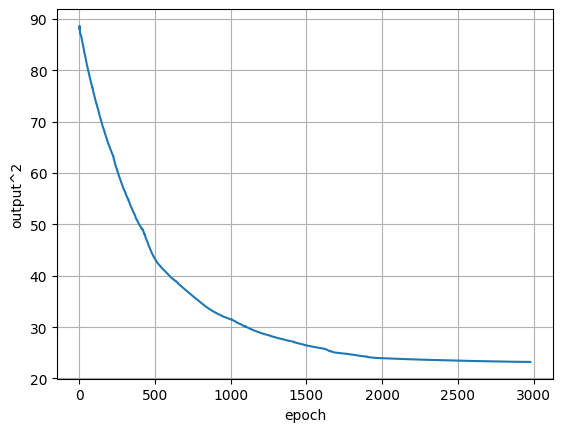

In [370]:
plt.plot(A.loss_rcd)
plt.ylabel('output^2')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

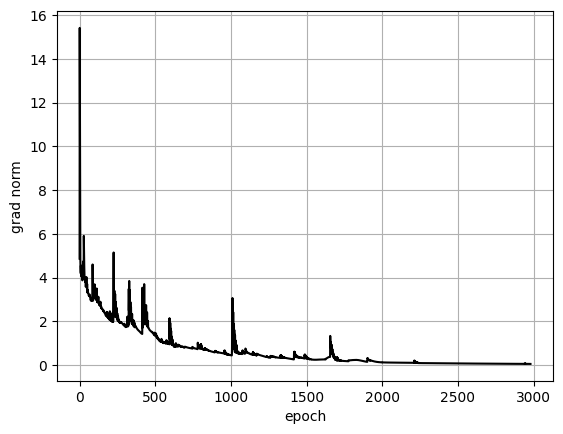

In [371]:
#plt.plot(A.gnorm_strides,color='blue')
#plt.plot(A.gnorm_winlen,color='red')
plt.plot(A.gnorm_total,color='black')
plt.ylabel('grad norm')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

---

In [284]:
B=WindowingModule(signal,10,16,4,1000,tapering_function='hann')
B(signal)

tensor(7.9118, grad_fn=<SumBackward0>)

In [285]:
target_value = torch.tensor(0.0,device=B.device) # Dummy target value for optimization example
optimizer_strides = torch.optim.Adam([B.strides], lr=0.001)
optimizer_winlen = torch.optim.Adam([B.win_length], lr=0.001)
for _ in range(5000):
    optimizer_strides.zero_grad()
    optimizer_winlen.zero_grad()
    output = B(signal)
    loss = F.mse_loss(output, target_value)
    loss.backward()
    B.save_train_info(loss.detach().numpy())
    optimizer_strides.step()
    optimizer_winlen.step()

print(B(signal).data)

tensor(4.5138)


In [286]:
print(A.loss_rcd==B.loss_rcd)
print(all(torch.equal(a, b) for a, b in zip(A.strides_lt, B.strides_lt)))
print(all(torch.equal(a, b) for a, b in zip(A.winlen_lt, B.winlen_lt)))
print(all(torch.equal(a, b) for a, b in zip(A.gd_strides_lt, B.gd_strides_lt)))
print(all(torch.equal(a, b) for a, b in zip(A.gd_winlen_lt, B.gd_winlen_lt)))
print(A.gnorm_strides==B.gnorm_strides)
print(A.gnorm_winlen==B.gnorm_winlen)
print(A.gd_v_ratio_strides==B.gd_v_ratio_strides)
print(A.gd_v_ratio_winlen==B.gd_v_ratio_winlen)

True
True
True
True
True
True
True
True
True


---

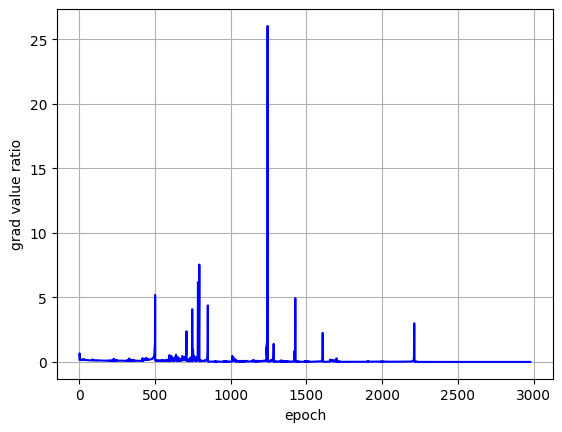

In [372]:
plt.plot(A.gd_v_ratio_strides,color='blue')
#plt.plot(A.gd_v_ratio_winlen,color='red')
#plt.plot(A.gd_v_ratio_total,color='black')
plt.ylabel('grad value ratio')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

In [297]:
index=4661
print(A.strides_lt[index])
print(A.gd_strides_lt[index])
print(torch.abs(A.gd_strides_lt[index])/torch.abs(A.strides_lt[index]))
print(torch.mean(torch.abs(A.gd_strides_lt[index])/torch.abs(A.strides_lt[index])))
print(A.gd_v_ratio_strides[index])

tensor([9.4055e-01, 9.5143e-01, 4.7796e+00, 8.4907e+00, 6.5372e+00, 3.0396e-01,
        7.6233e+00, 6.5221e-01, 1.3512e+00, 8.7257e+00, 1.1178e+00, 2.7399e+00,
        8.2741e+00, 7.3815e+00, 1.0619e+00, 1.3585e+00, 1.6486e+00, 5.3195e+00,
        7.3663e+00, 6.2748e-01, 8.1670e+00, 9.0613e-01, 1.2024e-04, 8.0162e+00,
        7.9596e-01])
tensor([ 0.1152,  0.1114, -0.0048, -0.5786,  0.0107,  0.1134, -0.1252,  0.0593,
         0.0734, -0.3846,  0.1112,  0.0145, -0.4448, -0.0707,  0.0872,  0.0102,
         0.0820, -0.1164, -0.0803,  0.1351, -0.1377,  0.0801,  0.0625, -0.1569,
         0.0291])
tensor([1.2253e-01, 1.1708e-01, 1.0112e-03, 6.8144e-02, 1.6326e-03, 3.7308e-01,
        1.6422e-02, 9.0993e-02, 5.4343e-02, 4.4079e-02, 9.9471e-02, 5.2948e-03,
        5.3755e-02, 9.5785e-03, 8.2095e-02, 7.5414e-03, 4.9761e-02, 2.1873e-02,
        1.0899e-02, 2.1527e-01, 1.6859e-02, 8.8449e-02, 5.1943e+02, 1.9570e-02,
        3.6587e-02])
tensor(20.8415)
20.841534


---

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0012, 0.0514, 0.3140, 0.7622, 1.0000,
        0.7527, 0.3052, 0.0485, 0.0016, 0.0000, 0.0000, 0.0000])


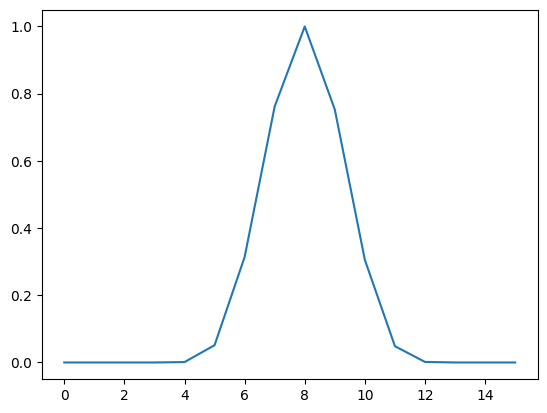

In [43]:
print(A.tap_win[:,-3].data)
plt.plot(A.tap_win[:,-3].detach().numpy())
plt.show()

___ 

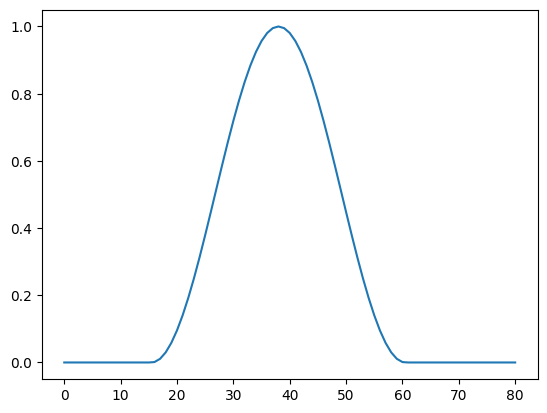

In [30]:
M=81
theta=45
shift=2
n=torch.arange(0,M)+shift
w1=0.5-0.5*torch.cos(2*torch.pi*(n+(theta-M+1)/2)/theta)
w1[n<=torch.floor(torch.tensor((M-1-theta)/2))]=0
w1[n>=torch.ceil(torch.tensor((M-1+theta)/2))]=0
plt.plot(w1.detach().numpy())

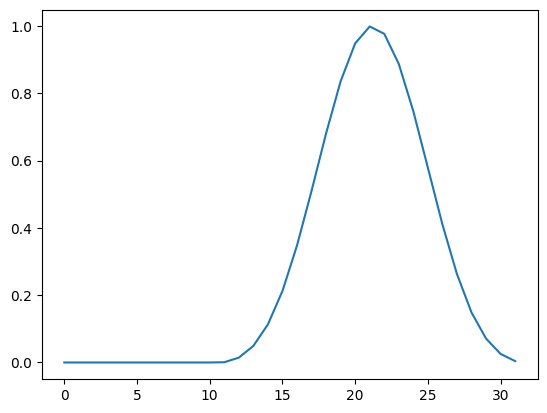

In [98]:
M=torch.tensor(32)
theta=torch.tensor(21)
shift=torch.tensor(-5.7)

n=torch.arange(0,M)+shift
w_b=0.42-0.5*torch.cos(2*torch.pi*(n+(theta-M+1)/2)/theta)+0.08*torch.cos(4*torch.pi*(n+(theta-M+1)/2)/theta)
w_b[n<=torch.floor((M-1-theta)/2)]=0
w_b[n>=torch.ceil((M-1+theta)/2)]=0
plt.plot(w_b.detach().numpy())

In [99]:
def windows_hann(N,theta,shift,alpha=0.5):
    # N: support
    # theta: time resolution
    # shift: additional desplecement respect to the center of the support window
    n=torch.arange(0,N)[:, None].expand([-1,len(shift)])-shift
    w=alpha-(1-alpha)*torch.cos(2*torch.pi*(n+(theta-N+1)/2)/theta)
    w[n<=torch.floor((N-1-theta)/2)]=0
    w[n>=torch.ceil((N-1+theta)/2)]=0
    return w

def window_gaussian(N,theta,shift,coef=4):
    sigma=theta/coef
    n=torch.arange(0,A.N)[:, None].expand([-1,len(shift)])-shift
    w=torch.exp(-0.5*((n-(N-1)/2)/sigma)**2)
    return w

def window_blackman(N,theta,shift):
    n=torch.arange(0,N)[:, None].expand([-1,len(shift)])-shift
    w=0.42-0.5*torch.cos(2*torch.pi*(n+(theta-N+1)/2)/theta)+0.08*torch.cos(4*torch.pi*(n+(theta-N+1)/2)/theta)
    w[n<=torch.floor((N-1-theta)/2)]=0
    w[n>=torch.ceil((N-1+theta)/2)]=0
    return w

In [102]:
W_test=window_blackman(A.N,A.actual_win_length,A.frames-torch.floor(A.frames))
print(W_test.shape)

torch.Size([16, 25])


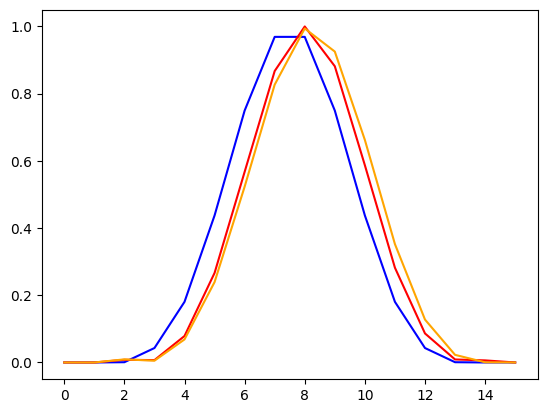

In [104]:
plt.plot(W_test[:,0].detach().numpy(),color='blue')
plt.plot(W_test[:,17].detach().numpy(),color='red')
plt.plot(W_test[:,21].detach().numpy(),color='orange')

In [81]:
fold_sx,idx_f=A.segment_signal(signal)

In [85]:
print(fold_sx.shape)
print(A.tap_win.shape)

torch.Size([1, 25, 16])
torch.Size([16, 25])


In [111]:
product=fold_sx*(A.tap_win.permute(1,0))
product.shape

torch.Size([1, 25, 16])

In [124]:
product/A.actual_win_length.view(1, A.T, 1)


tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 7.6058e-04, 4.7440e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 1.8184e-04, 8.4105e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 1.9745e-03, 2.0464e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 2.8118e-04, 7.8421e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.2582e-04

In [103]:
torch.sum(product)

tensor(65.7930, grad_fn=<SumBackward0>)

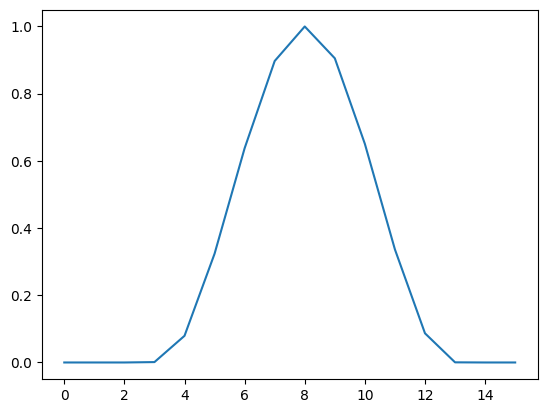

In [99]:
W=A.tap_win.permute(1,0)
plt.plot(W[-5,:].detach().numpy())